## Part 1: Importing Libraries

In [1]:
from src.modules import data_preprocessing as dp
from src.modules import data_visualization as dv
from src.modules import modeling as md

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## Part 2: Download Dataset

In [25]:
# Declare the ticker symbol. Here we use 5 stocks "AAPL MSFT AMD GOOG META" as an example.
ticker = "msft"

In [3]:
# Download the data from Yahoo Finance
df = dp.download_data(ticker)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-09,31.219999,31.790001,31.200001,31.660000,26.512556,49628500
2013-09-10,31.900000,32.400002,31.790001,32.389999,27.123859,56881200
2013-09-11,32.570000,32.930000,32.529999,32.740002,27.416960,39087500
2013-09-12,32.720001,32.779999,32.590000,32.689999,27.375076,32860200
2013-09-13,32.770000,33.070000,32.509998,33.029999,27.659807,40899000


## Part 3: EDA & Preprocessing

In [5]:
# Set global style
dv.set_global_style()

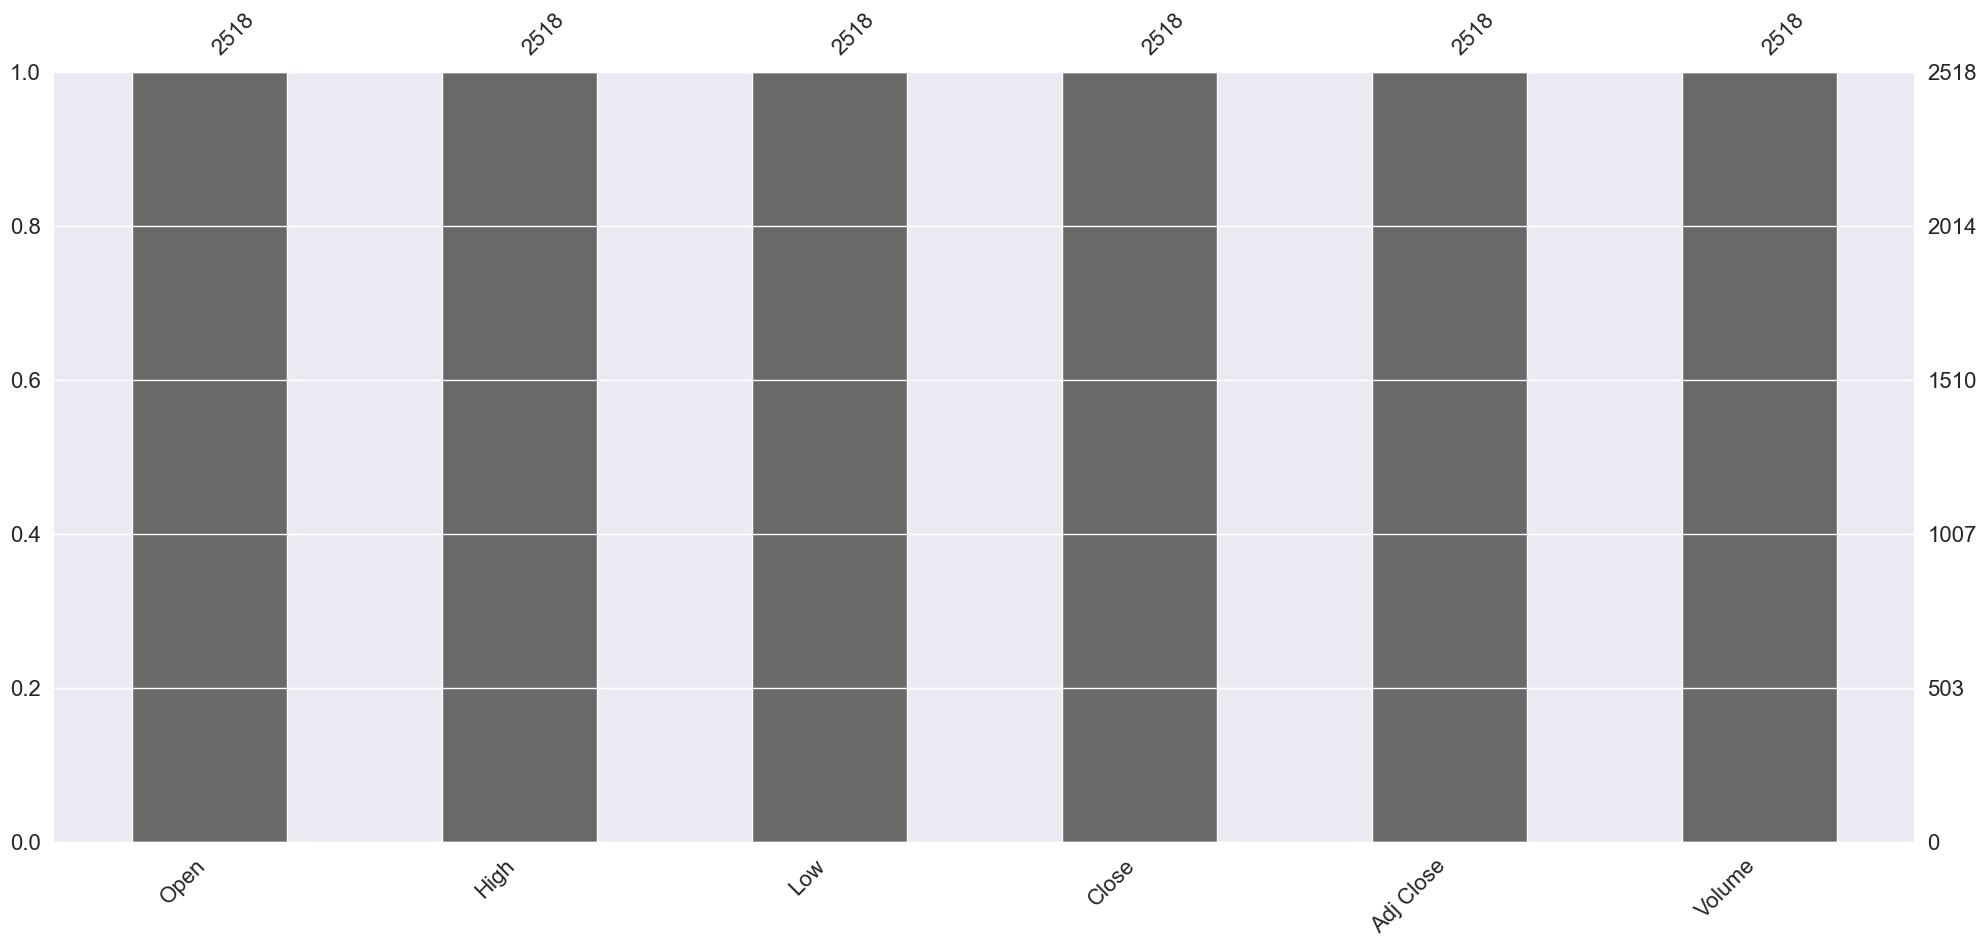

In [6]:
# Checking missing value
dv.plot_missing_values(df)

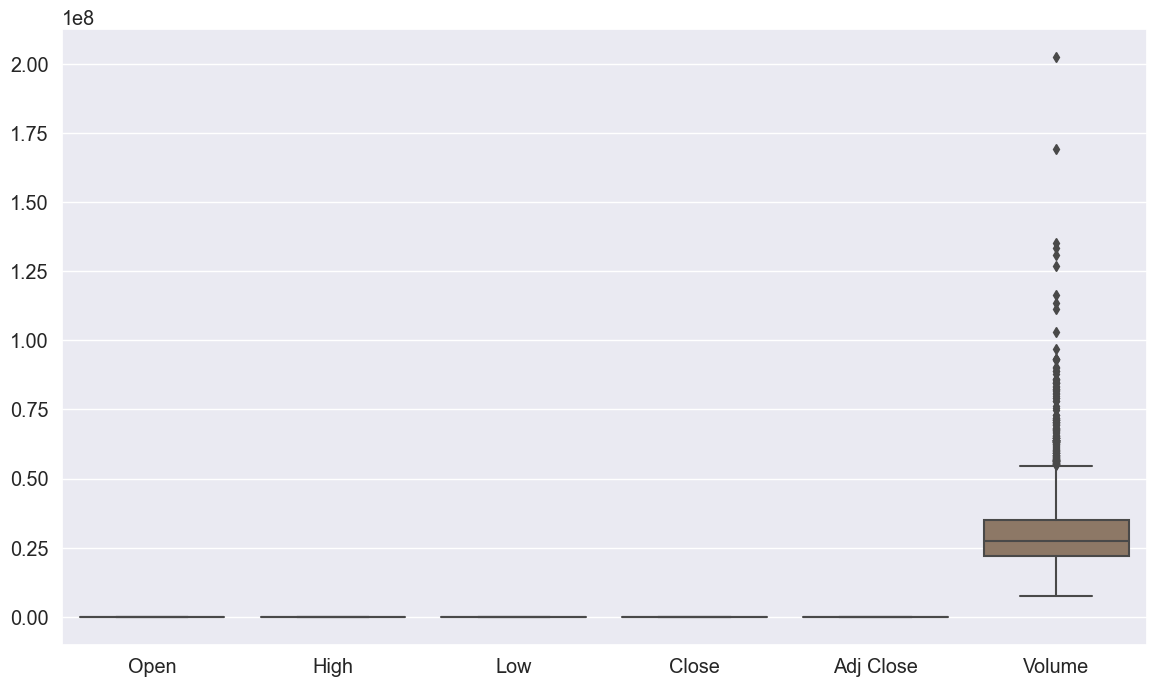

In [6]:
# Visualize the outliers data
dv.plot_outliers(df)

In [7]:
# Clean the data after checking the missing values and outliers
df = dp.clean_data(df)

In [8]:
# Change index to lowercase for convenience
df.index.name = df.index.name.lower()

## Part 4: Data Transformation

In [11]:
feat = ['adj close']

In [12]:
def scale_data(dataframe, feat):
    # get the adj close values
    close_data = dataframe.filter(feat)
    dataset = close_data.values

    # select a subset of the data for training purpose
    # the remaining set of the data is for validation
    # Get 80% of the data for training
    num_training_points = int(np.ceil(len(dataset) * 0.8))
    # X_train = dataset[0:num_training_points, :]
    # X_test = dataset[num_training_points:, :]

    # scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_dataset = scaler.fit_transform(dataset)

    # split the data into train and test scaled data sets
    scaled_data_train = scaled_dataset[0:int(num_training_points), :]
    # scaled_data_test = scaled_data[int(num_training_points)-window_size:, :]

    return dataset, scaled_dataset, scaled_data_train, num_training_points, scaler

## Part 5: Feature Engineering

In [13]:
def convert_to_supervised(data, window_size=60):
    # convert the data into a supervised learning problem
    # the number of time steps to look back is the window size
    # the next day's adjusted close price is the label

    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    
    X, y = np.array(X), np.array(y)

    # reshape the data into the shape accepted by the LSTM
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y

In [14]:
# Transform the data to supervised learning
window_size = 60 # window size is the number of previous days used to predict the next day. 

In [15]:
def get_features_labels(dataframe, ticker, window_size=60):
    dataset, scaled_dataset, scaled_data_train, num_training_points, scaler = scale_data(dataframe, feat)
    features, labels = convert_to_supervised(scaled_data_train, window_size)
    return features, labels, dataset, scaled_dataset, num_training_points, scaler

## Part 6: Modeling

In [19]:
def build_and_train_model(features, labels):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(features.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    # cp = ModelCheckpoint('model/', save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    # Train the model
    # history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1, callbacks=[cp])
    # epoch = 10 for developoment, need to increase to 100 for real training
    model.fit(features, labels, epochs = 50, batch_size = 32, verbose = 1)
    return model

In [20]:
features, labels, dataset, scaled_dataset, num_training_points, scaler = get_features_labels(dataframe=df, ticker=ticker, window_size=60)

In [21]:
model = build_and_train_model(features, labels)

Epoch 1/50
62/62 [==============================] - 21s 135ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699
Epoch 2/50
62/62 [==============================] - 8s 130ms/step - loss: 3.1108e-04 - root_mean_squared_error: 0.0176
Epoch 3/50
62/62 [==============================] - 8s 128ms/step - loss: 2.9838e-04 - root_mean_squared_error: 0.0173
Epoch 4/50
62/62 [==============================] - 8s 122ms/step - loss: 2.8791e-04 - root_mean_squared_error: 0.0170
Epoch 5/50
62/62 [==============================] - 7s 119ms/step - loss: 3.2093e-04 - root_mean_squared_error: 0.0179
Epoch 6/50
62/62 [==============================] - 7s 112ms/step - loss: 2.8992e-04 - root_mean_squared_error: 0.0170
Epoch 7/50
62/62 [==============================] - 7s 109ms/step - loss: 3.9353e-04 - root_mean_squared_error: 0.0198
Epoch 8/50
62/62 [==============================] - 8s 122ms/step - loss: 3.0440e-04 - root_mean_squared_error: 0.0174
Epoch 9/50
62/62 [==============================] -

In [21]:
# # Function to generate the future forecasts
# def predict(n_past = 0, n_future = 5):

#     # prepare data for forecasting
#     forecast_data = df[['adj close']].values

#     z = scaler.transform(forecast_data)

#     X, y = [], []

#     for i in range(window_size, len(z)):
#         X.append(z[i - window_size: i])
#         y.append(z[i])

#     X, y = np.array(X), np.array(y)

#     X_past = X[- n_past - 1:, :, :][:1]  # last observed input sequence
#     y_past = y[- n_past - 1]             # last observed target value
#     y_future = []                        # predicted target values

#     for i in range(n_past + n_future):

#         # feed the last forecast back to the model as an input
#         X_past = np.append(X_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

#         # generate the next forecast
#         y_past = model.predict(X_past)

#         # save the forecast
#         y_future.append(y_past.flatten()[0])
  
#     # transform the forecasts back to the original scale
#     y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

#     return y_future

In [22]:
# y_pred = predict()

In [23]:
# # Save the model for future use
# import pickle
# pickle.dump(model,open('model_goog.pkl','wb'))

In [27]:
model.save('model_'+ ticker + '.h5')